In [1]:
# MEJNw2
import sys
import glob
import os
sys.path.append("./")

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile

import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import regionmask

In [ ]:
def unzip_files_and_rename(directory: str):
  zip_files = glob.glob(f"{directory}/*.zip")
  print(f"Found {len(zip_files)} zip files")

  for file in zip_files:
    print("PROCESSING:", file)

    # Unzip the file:
    with zipfile.ZipFile(file, 'r') as zip_ref:
      zip_ref.extractall(directory)

    # All files uzip to data_0.nc, so we need to rename it to the original filename.
    filename = f"{directory}/data_0.nc"

    # Rename to match the original filename
    new_filename = f"{directory}/{file.split('/')[-1]}".replace(".zip", ".nc")
    os.rename(filename, new_filename)
    print(f"Renamed {filename} to {new_filename}")


def rename_nc_files_month_year(directory: str):
  for file in glob.glob(f"{directory}/*.nc"):
    print(file)

    ds = xr.open_dataset(file)
    month: int = ds.valid_time.dt.month.values[0]
    year: int = ds.valid_time.dt.year.values[0]
    print(f"This file is for {month}/{year}")

    # Rename to to the month and year
    new_filename = f"{directory}/../{year}_{month:02d}.nc"

    # If the file already exists, skip it
    if os.path.exists(new_filename):
      print(f"File {new_filename} already exists, skipping")
      continue

    # Move the file to the new filename
    os.rename(file, new_filename)
    print(f"Renamed {file} to {new_filename}")

# Unzip all files in the directory
# unzip_files_and_rename("./data/era5/zips")
rename_nc_files_month_year("./data/era5/zips")

In [ ]:
def calculate_monthly_hourly_means(filename: str):
  """Compress the data into a smaller file by calculating the mean of the data for each month and hour."""
  ds = xr.open_dataset(
    filename,
    # chunks={'valid_time': -1, 'latitude': 100, 'longitude': 100}
  )
  print("Opened dataset")

  # Get the month that this data represents
  month = ds.valid_time.dt.month.values[0]
  year = ds.valid_time.dt.year.values[0]

  # Create new coordinate arrays with round numbers
  new_lats = np.arange(-90, 90, 0.5)  # 0.5° grid from -90 to 90
  new_lons = np.arange(0, 360, 0.5)   # 0.5° grid from 0 to 359.5

  # Interpolate to the new grid (this preserves data better than simple slicing)
  downsampled = ds.interp(latitude=new_lats, longitude=new_lons)

  downsampled = downsampled.assign_coords(
    month=downsampled.valid_time.dt.month,
    hour=downsampled.valid_time.dt.hour
  )

  print("Assigned coords")

  # Group by month and hour and compute the mean
  # This will handle both t2m and ssrd variables
  monthly_hourly_means = downsampled.groupby(['month', 'hour']).mean()
  print(monthly_hourly_means)

  # Change the t2m variable to be float32
  monthly_hourly_means = monthly_hourly_means.astype({'t2m': 'float32', 'ssrd': 'float32'})

  print("Grouped by month and hour")

  # Save the results to a new, much smaller NetCDF file
  monthly_hourly_means.to_netcdf(f'outputs/month_hour_averages_{year}_{month}.nc')

  print("Saved results")

  # Close the dataset
  ds.close()


netcdf_files = sorted(glob.glob("./data/era5/*.nc"))
for file in netcdf_files:
  print(file)
  calculate_monthly_hourly_means(file)
  print("DONE")

In [5]:
# Merge the month-hour files into a single file:
merge_files = sorted(glob.glob("./outputs/month_hour_averages_*.nc"))
print(f"Found {len(merge_files)} files to merge")

if len(merge_files) != 12:
  raise ValueError(f"Expected 12 files, got {len(merge_files)}")

# Concatenate the files:
datasets = []

# Open each file and add to list
for file in merge_files:
  ds = xr.open_dataset(file)
  datasets.append(ds)
    
# Concatenate along the 'month' dimension
# Note: Make sure each file has a 'month' coordinate that's unique
combined_data = xr.concat(datasets, dim='month')
combined_data.to_netcdf("./outputs/complete_month_hour_data_2023.nc")
print("DONE")

Found 12 files to merge
DONE


In [26]:
ds = xr.open_dataset("./outputs/complete_month_hour_data_2023.nc")
# ds.t2m.isel(month=0).plot()
# plt.show()
# Convert the hour to local time based on the longitude
ds = ds.assign_coords(solar_hour=(ds.hour + ds.longitude / 15) % 24)

# print(ds)

# Calculate greenhouse heating and cooling degree hours
ideal_temp_daytime_celsius = 24
ideal_temp_nighttime_celsius = 18
ideal_temp_daytime_kelvin = ideal_temp_daytime_celsius + 273.15
ideal_temp_nighttime_kelvin = ideal_temp_nighttime_celsius + 273.15

print(f"Using ideal temp {ideal_temp_daytime_celsius}C for daytime and {ideal_temp_nighttime_celsius}C for nighttime")

# Calculate heating degree hours
# Daytime values are only valid for hours [6, 18]
daytime_heating_degree_hours = ideal_temp_daytime_kelvin - ds.t2m
daytime_cooling_degree_hours = ds.t2m - ideal_temp_daytime_kelvin

# Nighttime values are only valid for hours [18, 6]
nighttime_heating_degree_hours = ideal_temp_nighttime_kelvin - ds.t2m
nighttime_cooling_degree_hours = ds.t2m - ideal_temp_nighttime_kelvin

# Mask the daytime values outside of hours [6, 18]
daytime_heating_degree_hours = daytime_heating_degree_hours.where((ds.solar_hour < 6) | (ds.solar_hour > 18), 0)
daytime_cooling_degree_hours = daytime_cooling_degree_hours.where((ds.solar_hour < 6) | (ds.solar_hour > 18), 0)

# Mask the nighttime values outside of hours [18, 6]
nighttime_heating_degree_hours = nighttime_heating_degree_hours.where((ds.solar_hour > 6) & (ds.solar_hour < 18), 0)
nighttime_cooling_degree_hours = nighttime_cooling_degree_hours.where((ds.solar_hour > 6) & (ds.solar_hour < 18), 0)

# Calculate the total heating and cooling degree hours
total_heating_degree_hours = daytime_heating_degree_hours + nighttime_heating_degree_hours
total_cooling_degree_hours = daytime_cooling_degree_hours + nighttime_cooling_degree_hours

# Add the heating and cooling degree hours to the dataset
ds['heating_degree_hours'] = total_heating_degree_hours.clip(min=0)
ds['cooling_degree_hours'] = total_cooling_degree_hours.clip(min=0)

# Save the dataset
ds.to_netcdf("./outputs/month_hour_degree_hours_2023.nc")
ds

Using ideal temp 24C for daytime and 18C for nighttime


<xarray.Dataset> Size: 1GB
Dimensions:               (latitude: 360, longitude: 720, month: 12, hour: 24)
Coordinates:
  * month                 (month) int64 96B 1 10 11 12 2 3 4 5 6 7 8 9
  * hour                  (hour) int64 192B 0 1 2 3 4 5 6 ... 18 19 20 21 22 23
    number                int64 8B 0
  * latitude              (latitude) float64 3kB -90.0 -89.5 -89.0 ... 89.0 89.5
  * longitude             (longitude) float64 6kB 0.0 0.5 1.0 ... 359.0 359.5
    solar_hour            (hour, longitude) float64 138kB 0.0 0.03333 ... 22.97
Data variables:
    t2m                   (latitude, longitude, month, hour) float32 299MB 24...
    ssrd                  (latitude, longitude, month, hour) float32 299MB ...
    heating_degree_hours  (latitude, longitude, month, hour) float32 299MB 54...
    cooling_degree_hours  (latitude, longitude, month, hour) float32 299MB 0....
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-02-21T10:42 GRIB to CDM+CF via cfgrib-0.9.1...

In [27]:
print(ds)

<xarray.Dataset> Size: 1GB
Dimensions:               (latitude: 360, longitude: 720, month: 12, hour: 24)
Coordinates:
  * month                 (month) int64 96B 1 10 11 12 2 3 4 5 6 7 8 9
  * hour                  (hour) int64 192B 0 1 2 3 4 5 6 ... 18 19 20 21 22 23
    number                int64 8B 0
  * latitude              (latitude) float64 3kB -90.0 -89.5 -89.0 ... 89.0 89.5
  * longitude             (longitude) float64 6kB 0.0 0.5 1.0 ... 359.0 359.5
    solar_hour            (hour, longitude) float64 138kB 0.0 0.03333 ... 22.97
Data variables:
    t2m                   (latitude, longitude, month, hour) float32 299MB 24...
    ssrd                  (latitude, longitude, month, hour) float32 299MB ...
    heating_degree_hours  (latitude, longitude, month, hour) float32 299MB 54...
    cooling_degree_hours  (latitude, longitude, month, hour) float32 299MB 0....
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather 

In [15]:
def plot_xarray_map(dataset, variable, cmap='viridis', vmin=None, vmax=None, projection='PlateCarree', figsize=(12, 8), title=None):
  plt.rcParams['font.family'] = 'Helvetica Neue'
  # plt.rcParams['font.size'] = 12
  # Create a new figure with the specified projection
  proj = getattr(ccrs, projection)()
  fig = plt.figure(figsize=figsize)
  ax = fig.add_subplot(1, 1, 1, projection=proj)
  
  # Select the data for the specified month and hour
  # data_slice = dataset[variable].sel(month=month, hour=hour)
  # data_slice = dataset[variable]

  land_mask = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(dataset.longitude, dataset.latitude)
  land_mask = xr.where(~np.isnan(land_mask), True, False)
  masked_data = dataset.copy(deep=True)
  for var in masked_data.data_vars:
    masked_data[var] = masked_data[var].where(land_mask)

  # Set any zeroes to NaN so that they don't get plotted:
  # data_slice = data_slice.where(data_slice != 0, np.nan)
  data_slice = masked_data
  
  # Determine colormap min/max if not provided
  if vmin is None:
    vmin = data_slice[variable].min().item()
  if vmax is None:
    vmax = data_slice[variable].max().item()
  
  # Create the plot
  im = data_slice[variable].plot(ax=ax, transform=ccrs.PlateCarree(), 
                      cmap=cmap, vmin=vmin, vmax=vmax,
                      add_colorbar=False)
  
  # Add a colorbar
  cbar = plt.colorbar(im, ax=ax, orientation='horizontal', 
                      pad=0.05, shrink=0.8, extend='both')
  
  # Variable specific formatting and labels
  units = {
    't2m': '°C',
    'ssrd': 'W/m²',
    'heating_degree_hours': '°C·h',
    'cooling_degree_hours': '°C·h',
    'total_hvac_cost_no_humidity': '$/year',
    'total_hvac_cost_with_humidity': '$/year'
  }
  
  var_names = {
    't2m': 'Temperature at 2m',
    'ssrd': 'Surface Solar Radiation Downwards',
    'heating_degree_hours': 'Heating Degree Hours',
    'cooling_degree_hours': 'Cooling Degree Hours',
    'total_hvac_cost_no_humidity': 'Total HVAC Cost (no humidity control)',
    'total_hvac_cost_with_humidity': 'Total HVAC Cost'
  }
  
  # Set colorbar label
  cbar.set_label(f"{var_names.get(variable, variable)} ({units.get(variable, '')})")
  
  # Add map features
  ax.coastlines(resolution='110m')
  ax.add_feature(cfeature.BORDERS, linestyle=':')
  ax.add_feature(cfeature.LAKES, alpha=0.5)

  # Mask any values that are over an ocean:
  ax.add_feature(cfeature.OCEAN, alpha=1)
  
  # Add gridlines
  gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
  gl.top_labels = False
  gl.right_labels = False
  ax.set_title(title)
  
  plt.tight_layout()
  return fig

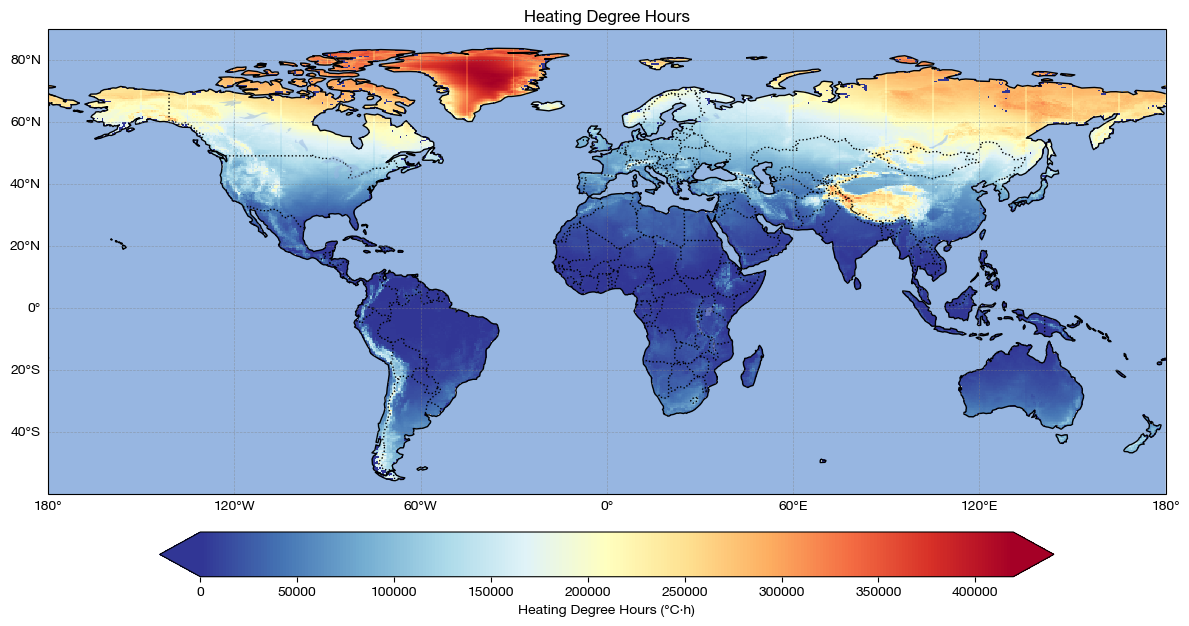

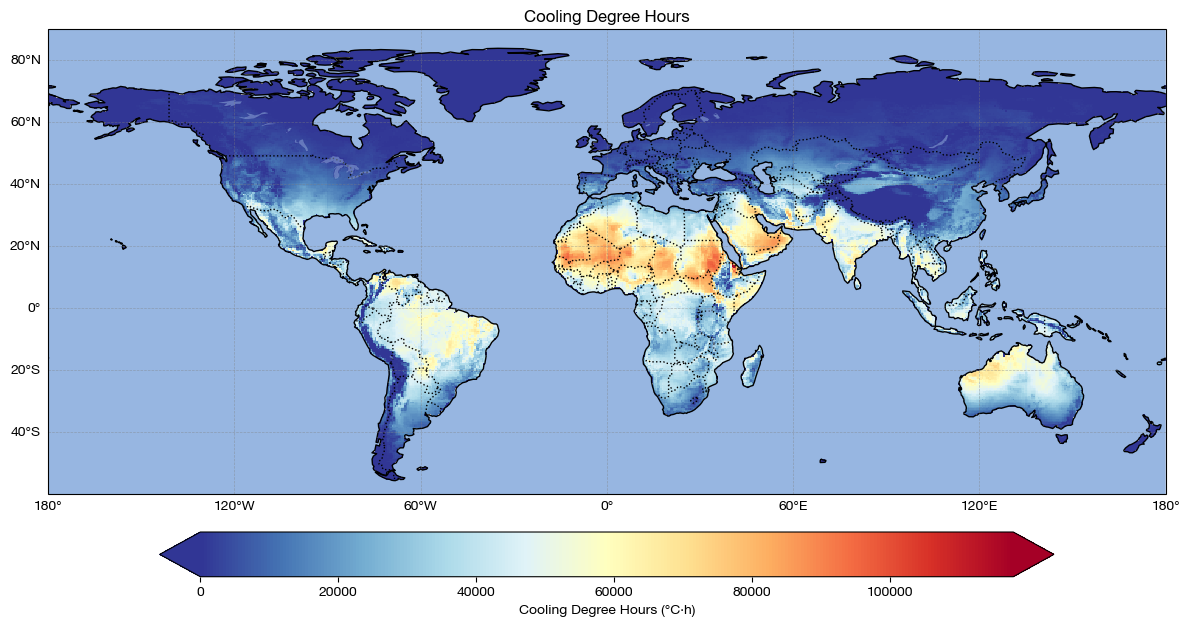

In [13]:
# Cut off the map so that it only shows latitudes > -60:
ds = xr.open_dataset("./outputs/month_hour_degree_hours_2023.nc")
ds_subset = ds.where(ds.latitude > -60, drop=True)

# Add up all months and hours to get the total heating degree hours:
hdh = ds_subset['heating_degree_hours'].sum(dim=['month', 'hour'])
cdh = ds_subset['cooling_degree_hours'].sum(dim=['month', 'hour'])
t2m = ds_subset['t2m'].mean(dim=['month', 'hour'])
ssrd = ds_subset['ssrd'].sum(dim=['month', 'hour'])

ds_total = xr.merge([hdh, cdh, t2m, ssrd])
# We've summed an average day for each month, so we need to multiply by 30 to get a month's worth:
ds_total['heating_degree_hours'] *= 30
ds_total['cooling_degree_hours'] *= 30
ds_total.to_netcdf("./outputs/total_degree_hours_2023.nc")

# Plot histogram of cooling degree hours:
# cdh.plot.hist(bins=50, edgecolor='black')
# plt.savefig('./outputs/cdh_histogram.png', dpi=300)
# plt.show()

# Plot histogram of heating degree hours:
# hdh.plot.hist(bins=50, edgecolor='black')
# plt.savefig('./outputs/hdh_histogram.png', dpi=300)
# plt.show()

fig = plot_xarray_map(ds_total, variable='heating_degree_hours', title='Heating Degree Hours', cmap='RdYlBu_r')
plt.savefig('./outputs/hdh_total_map.png', dpi=300)
plt.show()

fig = plot_xarray_map(ds_total, variable='cooling_degree_hours', title='Cooling Degree Hours', cmap='RdYlBu_r')
plt.savefig('./outputs/cdh_total_map.png', dpi=300)
plt.show()

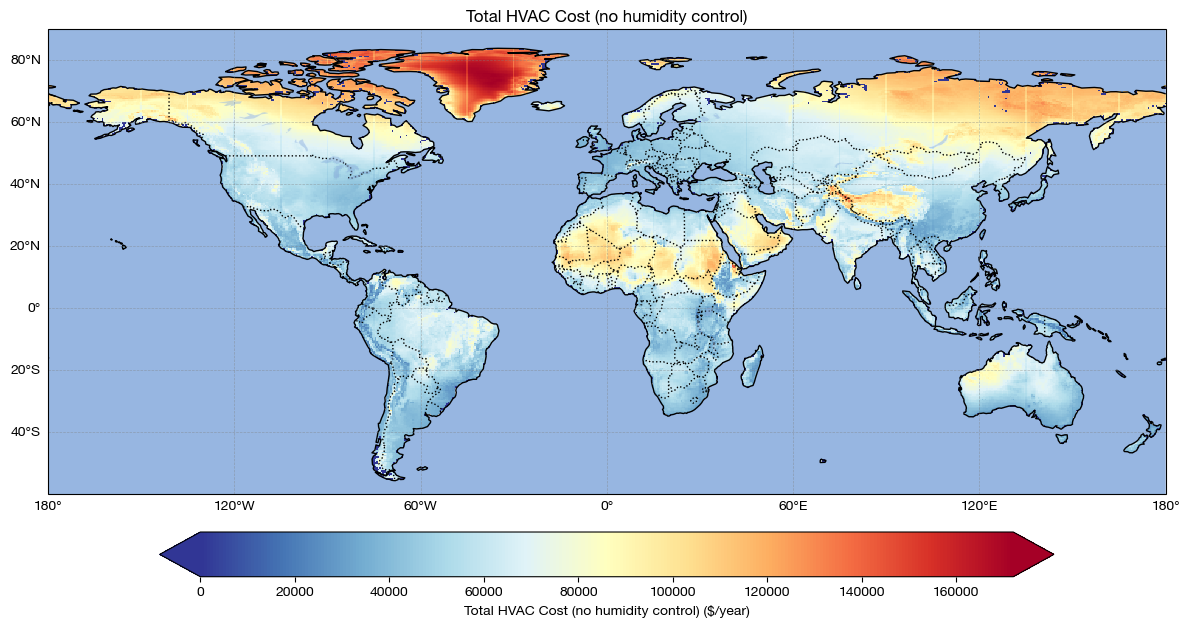

In [ ]:
ds_total = xr.open_dataset("./outputs/total_degree_hours_2023.nc")

heating_degree_hour_cost_factor = 0.41 # $/degree-hour
cooling_degree_hour_cost_factor = 1.23 # $/degree-hour

heating_degree_hours_cost = ds_total['heating_degree_hours'] * heating_degree_hour_cost_factor
cooling_degree_hours_cost = ds_total['cooling_degree_hours'] * cooling_degree_hour_cost_factor
total_cost = heating_degree_hours_cost + cooling_degree_hours_cost

cost_50th_percentile = np.percentile(total_cost, 50)
cost_90th_percentile = np.percentile(total_cost, 90)
print(f"50th percentile $/year: {cost_50th_percentile}")
print(f"90th percentile $/year: {cost_90th_percentile}")

ds_total['total_hvac_cost_no_humidity'] = total_cost

plot_xarray_map(ds_total, variable='total_hvac_cost_no_humidity', title='Total HVAC Cost (no humidity control)', cmap='RdYlBu_r')
plt.savefig('./outputs/total_hvac_cost_no_humidity_map_full_range.png', dpi=300)
plt.show()

plot_xarray_map(
  ds_total,
  variable='total_hvac_cost_no_humidity',
  title='Total HVAC Cost (no humidity control)',
  cmap='RdYlBu_r',
  vmax=120000
)
plt.savefig('./outputs/total_hvac_cost_no_humidity_map_clipped.png', dpi=300)
plt.show()